# Convolutional Neural Networks (CNNs)

**Deep Learning - University of Vermont**

This notebook follows the structure from *Dive into Deep Learning* (D2L):
1. **Why CNNs?** - The parameter explosion problem with MLPs
2. **Convolution Operation** - Understanding how convolution works
3. **LeNet-5** - The first successful CNN architecture
4. **AlexNet** - The network that started the deep learning revolution
5. **Parameter Comparison** - CNN vs MLP efficiency

**Main References:**
- D2L Chapter 7.1: https://d2l.ai/chapter_convolutional-neural-networks/why-conv.html
- D2L Chapter 7.2: https://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html
- D2L Chapter 7.6: https://d2l.ai/chapter_convolutional-neural-networks/lenet.html
- D2L Chapter 8.1: https://d2l.ai/chapter_convolutional-modern/alexnet.html

---

## 1. Why Do We Need CNNs?

**See Lecture Slides: Motivation for CNNs**

### 1.1 The Problem with MLPs for Images

MLPs have a critical problem: **they don't scale to real-world images**.

**Example from D2L:**
Consider a 1 megapixel image (1000×1000 pixels) with a hidden layer of 1000 neurons:

- Input dimension: $1000 \times 1000 = 1,000,000$ pixels
- First layer parameters: $1,000,000 \times 1000 = 1,000,000,000$ (1 billion!)
- Just for **one layer**

### 1.2 Two Key Insights

CNNs exploit two fundamental properties of images:

#### 1. Translation Invariance
An object is the same object regardless of where it appears in the image. A cat in the top-left corner is still a cat if it appears in the bottom-right.

#### 2. Locality  
Nearby pixels are more strongly related than distant pixels. To detect edges, we only need to look at neighboring pixels, not the entire image.

These two insights lead to:
- **Local connectivity:** Each neuron connects only to a small region
- **Weight sharing:** The same filter is applied across the entire image

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.4.1+cpu
Device: CPU


In [2]:
# Parameter comparison for different image sizes
def calculate_mlp_params(h, w, c, hidden_units):
    """Calculate parameters for MLP first layer"""
    input_dim = h * w * c
    params = input_dim * hidden_units + hidden_units
    memory_gb = params * 4 / (1024**3)  # float32 = 4 bytes
    return params, memory_gb

def calculate_conv_params(in_channels, out_channels, kernel_size):
    """Calculate parameters for convolutional layer"""
    params = in_channels * out_channels * kernel_size * kernel_size + out_channels
    return params

configs = [
    ('MNIST', 28, 28, 1),
    ('CIFAR-10', 32, 32, 3),
    ('Tiny ImageNet', 64, 64, 3),
    ('ImageNet', 224, 224, 3),
    ('HD Image', 1920, 1080, 3)
]

hidden_units = 1000

print(f"{'Dataset':<20} {'Input Dim':<12} {'MLP Params':<20} {'CNN Params':<15} {'Reduction'}")
print("="*90)

for name, h, w, c in configs:
    mlp_params, memory = calculate_mlp_params(h, w, c, hidden_units)
    cnn_params = calculate_conv_params(c, 64, 3)  # 64 filters, 3×3 kernel
    reduction = mlp_params / cnn_params
    
    print(f"{name:<20} {h*w*c:>10,}   {mlp_params:>18,}   {cnn_params:>13,}   {reduction:>10.0f}x")

print("\n💡 Key Insight from D2L:")
print("   CNNs reduce parameters by 4+ orders of magnitude!")
print("   This is possible through local connectivity and weight sharing.")

Dataset              Input Dim    MLP Params           CNN Params      Reduction
MNIST                       784              785,000             640         1227x
CIFAR-10                  3,072            3,073,000           1,792         1715x
Tiny ImageNet            12,288           12,289,000           1,792         6858x
ImageNet                150,528          150,529,000           1,792        84001x
HD Image              6,220,800        6,220,801,000           1,792      3471429x

💡 Key Insight from D2L:
   CNNs reduce parameters by 4+ orders of magnitude!
   This is possible through local connectivity and weight sharing.


## 2. The Convolution Operation


**See Lecture Slides: Convolution Mechanics**

### 2.1 Cross-Correlation (What We Actually Do)

**From D2L:**
> "Recall that strictly speaking, convolutional layers are a misnomer, since the operations they express are more accurately described as cross-correlations."

The **2D cross-correlation** operation:

$$
[\mathbf{H}]_{i,j} = \sum_{a=1}^{h} \sum_{b=1}^{w} [\mathbf{V}]_{a,b} \cdot [\mathbf{X}]_{i+a-1, j+b-1}
$$

Where:
- $\mathbf{X}$ is the input (image)
- $\mathbf{V}$ is the kernel/filter (learned weights)
- $\mathbf{H}$ is the output (feature map)

### 2.2 How It Works

1. **Slide** the kernel over the input
2. **Element-wise multiply** kernel with the region
3. **Sum** all products
4. **Store** result in output
5. **Move** to next position

In [3]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

# Test with a simple example from D2L
X = torch.tensor([[0., 1., 2.],
                  [3., 4., 5.],
                  [6., 7., 8.]])
K = torch.tensor([[0., 1.],
                  [2., 3.]])

Y = corr2d(X, K)
print("Input X:")
print(X)
print("\nKernel K:")
print(K)
print("\nOutput Y:")
print(Y)

Input X:
tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

Kernel K:
tensor([[0., 1.],
        [2., 3.]])

Output Y:
tensor([[19., 25.],
        [37., 43.]])


### 2.3 Stride and Padding

**See Lecture Slides: Stride and Padding**

#### Output Dimension Formula

Given:
- Input size: $n_h \times n_w$
- Kernel size: $k_h \times k_w$
- Padding: $p_h \times p_w$
- Stride: $s_h \times s_w$

**Output dimensions:**
$$
\begin{aligned}
\text{output height} &= \left\lfloor \frac{n_h - k_h + p_h + s_h}{s_h} \right\rfloor \\
\text{output width} &= \left\lfloor \frac{n_w - k_w + p_w + s_w}{s_w} \right\rfloor
\end{aligned}
$$

#### Why Padding?
- **Preserve spatial dimensions:** Without padding, each convolution shrinks the output
- **Use edge information:** Padding allows kernels to process border pixels

#### Why Stride?
- **Downsampling:** Larger strides reduce spatial dimensions
- **Computational efficiency:** Fewer computations with stride > 1

#### Weight Sharing
The same kernel is applied to every position in the input. This means:
- **Parameters:** Only $k_h \times k_w \times C_{in} \times C_{out}$ weights
- **Computations:** Applied to $(n_h - k_h + 1) \times (n_w - k_w + 1)$ positions
- **Benefit:** Massive parameter reduction compared to fully connected layers

In [4]:
def calc_output_size(input_size, kernel_size, padding=0, stride=1):
    """Calculate output size after convolution"""
    return (input_size - kernel_size + 2 * padding + stride) // stride

# Examples
print("Output Dimension Calculations:\n")
print(f"{'Input':<10} {'Kernel':<10} {'Padding':<10} {'Stride':<10} {'Output':<10}")
print("="*50)

examples = [
    (28, 5, 0, 1),  # No padding, stride 1
    (28, 5, 2, 1),  # Same padding
    (28, 5, 0, 2),  # Stride 2, no padding
    (28, 3, 1, 1),  # 3x3 kernel with padding 1
    (224, 11, 2, 4), # AlexNet first layer
    (55, 3, 1, 1),  # Preserving dimensions
]

for inp, ker, pad, stride in examples:
    out = calc_output_size(inp, ker, pad, stride)
    print(f"{inp:<10} {ker:<10} {pad:<10} {stride:<10} {out:<10}")

print("\n💡 Key Insight:")
print("   Padding = (kernel_size - 1) / 2 preserves dimensions with stride=1")
print("   For 3×3 kernel: padding=1 keeps same size")
print("   For 5×5 kernel: padding=2 keeps same size")

Output Dimension Calculations:

Input      Kernel     Padding    Stride     Output    
28         5          0          1          24        
28         5          2          1          28        
28         5          0          2          12        
28         3          1          1          28        
224        11         2          4          55        
55         3          1          1          55        

💡 Key Insight:
   Padding = (kernel_size - 1) / 2 preserves dimensions with stride=1
   For 3×3 kernel: padding=1 keeps same size
   For 5×5 kernel: padding=2 keeps same size


### 2.4 Edge Detection Example

Let's use convolution to detect edges in an image.

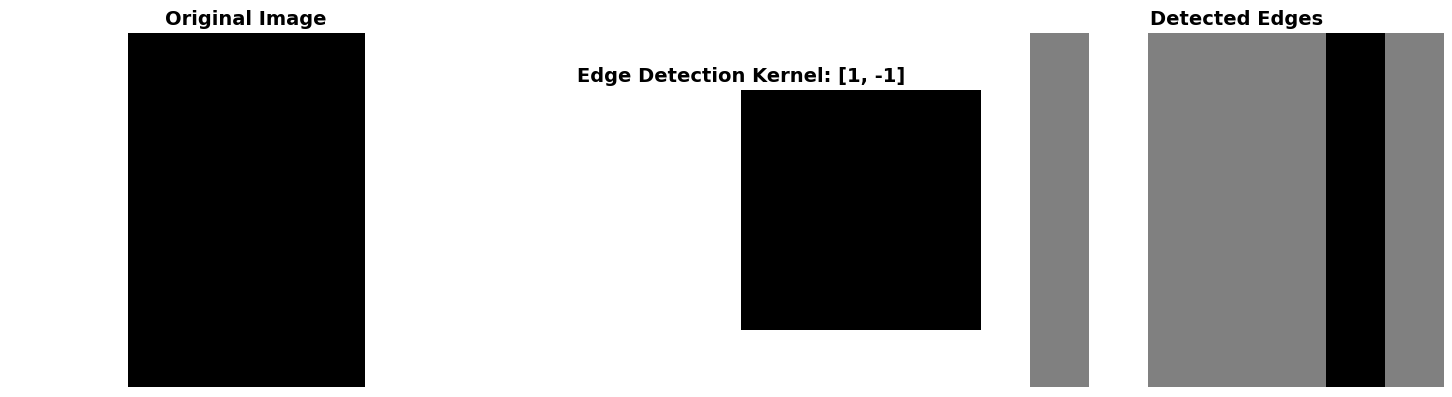

Output Y (edge detection):
tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

Notice: 1 detects white-to-black transition, -1 detects black-to-white


In [5]:
# Create a simple image: white square on black background
X = torch.ones((6, 8))
X[:, 2:6] = 0

# Edge detection kernel
K = torch.tensor([[1., -1.]])

# Apply convolution
Y = corr2d(X, K)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(X, cmap='gray')
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(K, cmap='gray')
axes[1].set_title('Edge Detection Kernel: [1, -1]', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(Y, cmap='gray')
axes[2].set_title('Detected Edges', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Output Y (edge detection):")
print(Y)
print("\nNotice: 1 detects white-to-black transition, -1 detects black-to-white")

## 3. LeNet-5: The First Successful CNN


**See Lecture Slides: LeNet Architecture**

### 3.1 Architecture

**From D2L:**
> "At a high level, LeNet (LeNet-5) consists of two parts: (i) a convolutional encoder consisting of two convolutional layers; and (ii) a dense block consisting of three fully connected layers."

**LeNet-5 Structure:**
```
Input (1×28×28)
  ↓
Conv1: 5×5, 6 filters → (6×28×28)
  ↓ Sigmoid
AvgPool: 2×2 → (6×14×14)
  ↓
Conv2: 5×5, 16 filters → (16×10×10)
  ↓ Sigmoid
AvgPool: 2×2 → (16×5×5)
  ↓ Flatten
FC1: 120 units
  ↓ Sigmoid
FC2: 84 units
  ↓ Sigmoid
FC3: 10 units (output)
```


In [6]:
# Load Fashion-MNIST
transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [7]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        # Convolutional encoder
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Dense block
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        # Conv block 1
        x = torch.sigmoid(self.conv1(x))
        x = self.pool1(x)
        
        # Conv block 2
        x = torch.sigmoid(self.conv2(x))
        x = self.pool2(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lenet = LeNet().to(device)

print(lenet)
print(f"\nTotal parameters: {sum(p.numel() for p in lenet.parameters()):,}")

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Total parameters: 61,706


In [8]:
# Detailed parameter count
print("\nLeNet-5 Parameter Breakdown:")
print(f"{'Layer':<20} {'Output Shape':<20} {'Parameters':<15}")
print("="*55)

# Trace through with a sample input
x = torch.randn(1, 1, 28, 28).to(device)

total_params = 0
for name, layer in lenet.named_children():
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        params = sum(p.numel() for p in layer.parameters())
        total_params += params
        x = layer(x) if not isinstance(layer, nn.Linear) else layer(x.view(x.size(0), -1))
        print(f"{name:<20} {str(tuple(x.shape)):<20} {params:>15,}")
    elif isinstance(layer, nn.AvgPool2d):
        x = layer(x)
        print(f"{name:<20} {str(tuple(x.shape)):<20} {0:>15,}")

print("="*55)
print(f"{'TOTAL':<40} {total_params:>15,}")


LeNet-5 Parameter Breakdown:
Layer                Output Shape         Parameters     
conv1                (1, 6, 28, 28)                   156
pool1                (1, 6, 14, 14)                     0
conv2                (1, 16, 10, 10)                2,416
pool2                (1, 16, 5, 5)                      0
fc1                  (1, 120)                      48,120
fc2                  (1, 84)                       10,164
fc3                  (1, 10)                          850
TOTAL                                             61,706


In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        
        outputs = model(X)
        loss = criterion(outputs, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

In [10]:
# Train LeNet
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet.parameters(), lr=0.9)

num_epochs = 10
lenet_train_losses = []
lenet_test_accs = []

print("Training LeNet-5...\n")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(lenet, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(lenet, test_loader, criterion, device)
    
    lenet_train_losses.append(train_loss)
    lenet_test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Acc: {test_acc:.2f}%")

print(f"\nFinal LeNet Test Accuracy: {lenet_test_accs[-1]:.2f}%")

Training LeNet-5...

Epoch  1/10 | Train Loss: 2.3162, Train Acc: 9.94% | Test Acc: 10.00%
Epoch  2/10 | Train Loss: 2.3047, Train Acc: 10.07% | Test Acc: 10.00%
Epoch  3/10 | Train Loss: 2.3042, Train Acc: 9.78% | Test Acc: 10.00%
Epoch  4/10 | Train Loss: 2.3037, Train Acc: 10.02% | Test Acc: 10.00%
Epoch  5/10 | Train Loss: 2.3028, Train Acc: 10.22% | Test Acc: 10.00%
Epoch  6/10 | Train Loss: 2.2113, Train Acc: 16.59% | Test Acc: 27.88%
Epoch  7/10 | Train Loss: 1.3458, Train Acc: 46.67% | Test Acc: 56.13%
Epoch  8/10 | Train Loss: 0.9282, Train Acc: 62.25% | Test Acc: 65.23%
Epoch  9/10 | Train Loss: 0.8004, Train Acc: 68.79% | Test Acc: 71.57%
Epoch 10/10 | Train Loss: 0.7096, Train Acc: 72.35% | Test Acc: 73.33%

Final LeNet Test Accuracy: 73.33%


### 3.2 Visualizing Learned Filters

**See Lecture Slides: CNN Interpretability**

Let's visualize what the first convolutional layer has learned.

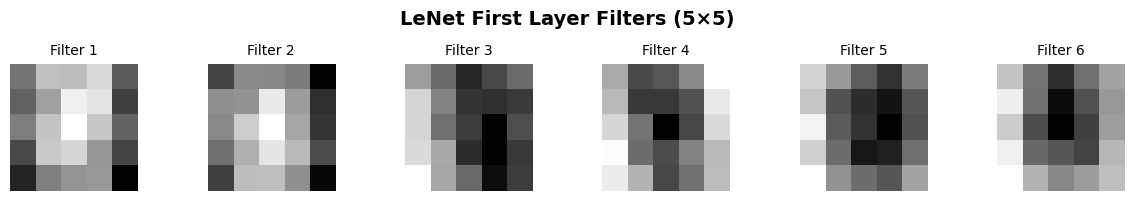


💡 What are these filters detecting?
   Each 5×5 filter learns to detect different low-level features:
   - Edges at different orientations
   - Corners and junctions
   - Texture patterns

   These are the building blocks for higher-level features!


In [11]:
# Visualize first layer filters
lenet.eval()
filters = lenet.conv1.weight.data.cpu()

fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    ax = axes[i]
    filter_img = filters[i, 0].numpy()
    ax.imshow(filter_img, cmap='gray')
    ax.set_title(f'Filter {i+1}', fontsize=10)
    ax.axis('off')

plt.suptitle('LeNet First Layer Filters (5×5)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 What are these filters detecting?")
print("   Each 5×5 filter learns to detect different low-level features:")
print("   - Edges at different orientations")
print("   - Corners and junctions")
print("   - Texture patterns")
print("\n   These are the building blocks for higher-level features!")

### 3.3 Visualizing Feature Maps

**See Lecture Slides: Feature Map Visualization**

Feature maps show what each layer "sees" in the image. Let's visualize activations at different layers.

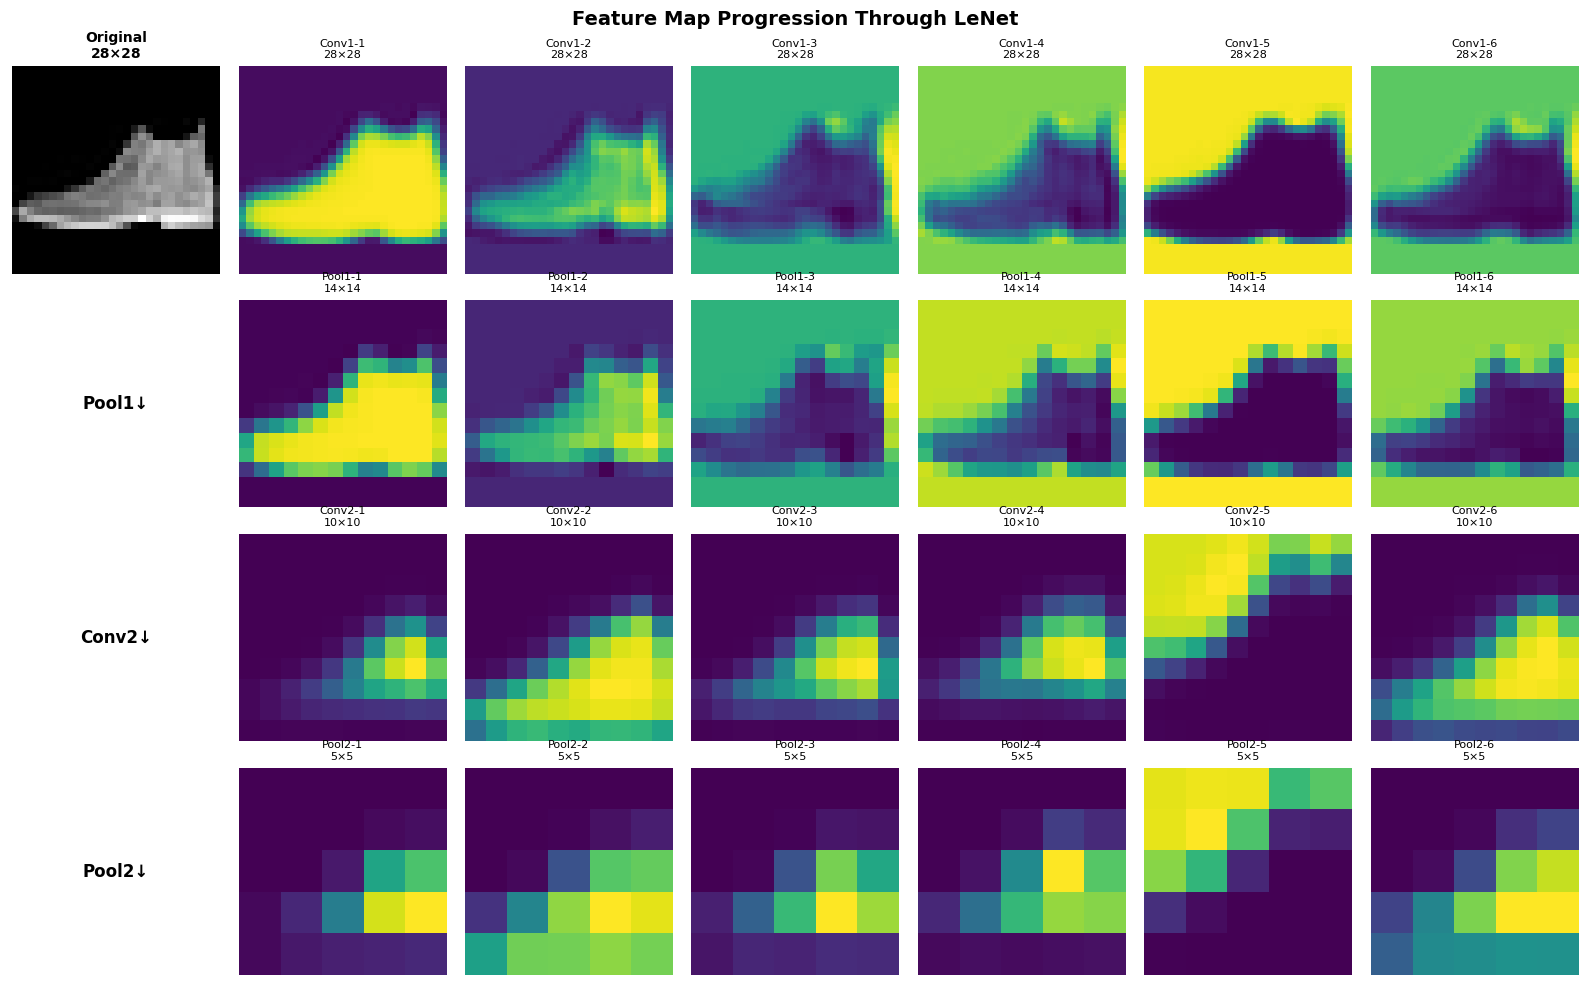


💡 Hierarchical Feature Learning:
   Layer 1 (Conv1): Detects edges, simple patterns (28×28)
   Layer 2 (Pool1): Downsamples, keeps important features (14×14)
   Layer 3 (Conv2): Combines edges into shapes, textures (10×10)
   Layer 4 (Pool2): Further abstraction (5×5)

   Notice: Spatial size ↓, but semantic meaning ↑


In [12]:
# Get a test image
test_images, test_labels = next(iter(test_loader))
test_img = test_images[0:1].to(device)  # Take first image

# Extract feature maps from each layer
with torch.no_grad():
    # After first conv + activation
    x1 = torch.sigmoid(lenet.conv1(test_img))
    # After first pooling
    x2 = lenet.pool1(x1)
    # After second conv + activation
    x3 = torch.sigmoid(lenet.conv2(x2))
    # After second pooling
    x4 = lenet.pool2(x3)

# Visualize
fig = plt.figure(figsize=(16, 10))

# Original image
ax = plt.subplot(4, 7, 1)
ax.imshow(test_images[0].squeeze(), cmap='gray')
ax.set_title('Original\n28×28', fontsize=10, fontweight='bold')
ax.axis('off')

# First conv layer (6 feature maps at 28×28)
for i in range(6):
    ax = plt.subplot(4, 7, i + 2)
    ax.imshow(x1[0, i].cpu(), cmap='viridis')
    ax.set_title(f'Conv1-{i+1}\n28×28', fontsize=8)
    ax.axis('off')

# After first pooling (6 feature maps at 14×14)
ax = plt.subplot(4, 7, 8)
ax.text(0.5, 0.5, 'Pool1↓', ha='center', va='center', fontsize=12, fontweight='bold')
ax.axis('off')

for i in range(6):
    ax = plt.subplot(4, 7, i + 9)
    ax.imshow(x2[0, i].cpu(), cmap='viridis')
    ax.set_title(f'Pool1-{i+1}\n14×14', fontsize=8)
    ax.axis('off')

# Second conv layer (show first 6 of 16 feature maps at 10×10)
ax = plt.subplot(4, 7, 15)
ax.text(0.5, 0.5, 'Conv2↓', ha='center', va='center', fontsize=12, fontweight='bold')
ax.axis('off')

for i in range(6):
    ax = plt.subplot(4, 7, i + 16)
    ax.imshow(x3[0, i].cpu(), cmap='viridis')
    ax.set_title(f'Conv2-{i+1}\n10×10', fontsize=8)
    ax.axis('off')

# After second pooling (show first 6 of 16 feature maps at 5×5)
ax = plt.subplot(4, 7, 22)
ax.text(0.5, 0.5, 'Pool2↓', ha='center', va='center', fontsize=12, fontweight='bold')
ax.axis('off')

for i in range(6):
    ax = plt.subplot(4, 7, i + 23)
    ax.imshow(x4[0, i].cpu(), cmap='viridis')
    ax.set_title(f'Pool2-{i+1}\n5×5', fontsize=8)
    ax.axis('off')

plt.suptitle('Feature Map Progression Through LeNet', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Hierarchical Feature Learning:")
print("   Layer 1 (Conv1): Detects edges, simple patterns (28×28)")
print("   Layer 2 (Pool1): Downsamples, keeps important features (14×14)")
print("   Layer 3 (Conv2): Combines edges into shapes, textures (10×10)")
print("   Layer 4 (Pool2): Further abstraction (5×5)")
print("\n   Notice: Spatial size ↓, but semantic meaning ↑")

### 3.4 Parameter Calculation Practice

**See Lecture Slides: Parameter Counting**

Let's practice calculating parameters for different layer types.

In [13]:
def count_conv_params(in_channels, out_channels, kernel_size, has_bias=True):
    """Calculate parameters for a convolutional layer"""
    weights = in_channels * out_channels * kernel_size * kernel_size
    bias = out_channels if has_bias else 0
    return weights + bias

def count_fc_params(in_features, out_features, has_bias=True):
    """Calculate parameters for a fully connected layer"""
    weights = in_features * out_features
    bias = out_features if has_bias else 0
    return weights + bias

print("Parameter Calculation Examples\n")
print("="*80)

# Example 1: LeNet Conv1
params = count_conv_params(1, 6, 5)
print(f"\n1. LeNet Conv1 (1→6 channels, 5×5 kernel):")
print(f"   Weights: 1 × 6 × 5 × 5 = 150")
print(f"   Bias: 6")
print(f"   Total: {params} ✓")

# Example 2: LeNet Conv2
params = count_conv_params(6, 16, 5)
print(f"\n2. LeNet Conv2 (6→16 channels, 5×5 kernel):")
print(f"   Weights: 6 × 16 × 5 × 5 = 2,400")
print(f"   Bias: 16")
print(f"   Total: {params} ✓")

# Example 3: AlexNet Conv1
params = count_conv_params(1, 96, 11)
print(f"\n3. AlexNet Conv1 (1→96 channels, 11×11 kernel):")
print(f"   Weights: 1 × 96 × 11 × 11 = 11,616")
print(f"   Bias: 96")
print(f"   Total: {params:,} ✓")

# Example 4: FC Layer
params = count_fc_params(16 * 5 * 5, 120)
print(f"\n4. LeNet FC1 (400→120):")
print(f"   Weights: 400 × 120 = 48,000")
print(f"   Bias: 120")
print(f"   Total: {params:,} ✓")

# Compare with MLP
mlp_params = count_fc_params(28 * 28, 256)
cnn_params = count_conv_params(1, 64, 3)

print(f"\n5. MLP vs CNN (for 28×28 input):")
print(f"   MLP (784→256): {mlp_params:,} parameters")
print(f"   CNN (1→64, 3×3): {cnn_params:,} parameters")
print(f"   Reduction: {mlp_params/cnn_params:.1f}x! 💡")

print("\n" + "="*80)
print("\n💡 Key Formula:")
print("   Conv layer: (C_in × C_out × K_h × K_w) + C_out")
print("   FC layer: (in_features × out_features) + out_features")
print("   Pooling layer: 0 parameters (just downsampling)")

Parameter Calculation Examples


1. LeNet Conv1 (1→6 channels, 5×5 kernel):
   Weights: 1 × 6 × 5 × 5 = 150
   Bias: 6
   Total: 156 ✓

2. LeNet Conv2 (6→16 channels, 5×5 kernel):
   Weights: 6 × 16 × 5 × 5 = 2,400
   Bias: 16
   Total: 2416 ✓

3. AlexNet Conv1 (1→96 channels, 11×11 kernel):
   Weights: 1 × 96 × 11 × 11 = 11,616
   Bias: 96
   Total: 11,712 ✓

4. LeNet FC1 (400→120):
   Weights: 400 × 120 = 48,000
   Bias: 120
   Total: 48,120 ✓

5. MLP vs CNN (for 28×28 input):
   MLP (784→256): 200,960 parameters
   CNN (1→64, 3×3): 640 parameters
   Reduction: 314.0x! 💡


💡 Key Formula:
   Conv layer: (C_in × C_out × K_h × K_w) + C_out
   FC layer: (in_features × out_features) + out_features
   Pooling layer: 0 parameters (just downsampling)


## 4. AlexNet: The Deep Learning Revolution

**See Lecture Slides: AlexNet and the ImageNet Challenge**

### 4.1 Historical Context

**From D2L:**
> "AlexNet, which employed an 8-layer CNN, won the ImageNet Large Scale Visual Recognition Challenge 2012 by a large margin. This network showed, for the first time, that the features obtained by learning can transcend manually-designed features, breaking the previous paradigm in computer vision."

### 4.2 Key Innovations

**From D2L Section 8.1:**

1. **Much Deeper:** 8 layers vs LeNet's 5
2. **ReLU Activation:** Instead of sigmoid
3. **Dropout:** For regularization
4. **Data Augmentation:** To increase training data
5. **GPU Training:** Made deep training feasible

### 4.3 Architecture

**AlexNet Structure:**
```
Input (1×224×224 for Fashion-MNIST, adapted)
  ↓
Conv1: 11×11, 96 filters, stride=4
  ↓ ReLU → MaxPool
Conv2: 5×5, 256 filters
  ↓ ReLU → MaxPool
Conv3: 3×3, 384 filters
  ↓ ReLU
Conv4: 3×3, 384 filters
  ↓ ReLU
Conv5: 3×3, 256 filters
  ↓ ReLU → MaxPool
  ↓ Flatten
FC1: 4096 units
  ↓ ReLU → Dropout
FC2: 4096 units
  ↓ ReLU → Dropout
FC3: 10 units
```

In [14]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        # Convolutional layers
        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv2
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv3
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Conv4
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            
            # Conv5
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 5 * 5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# For Fashion-MNIST, we need to resize to 224×224
transform_alexnet = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
])

train_dataset_alex = datasets.FashionMNIST('./data', train=True, download=True, transform=transform_alexnet)
test_dataset_alex = datasets.FashionMNIST('./data', train=False, transform=transform_alexnet)

train_loader_alex = DataLoader(train_dataset_alex, batch_size=128, shuffle=True)
test_loader_alex = DataLoader(test_dataset_alex, batch_size=128, shuffle=False)

alexnet = AlexNet().to(device)
print(f"AlexNet Total Parameters: {sum(p.numel() for p in alexnet.parameters()):,}")

AlexNet Total Parameters: 46,764,746


In [15]:
# AlexNet parameter breakdown
print("\nAlexNet Parameter Breakdown:")
print(f"{'Layer':<25} {'Parameters':<15}")
print("="*40)

conv_params = 0
fc_params = 0

for name, module in alexnet.named_modules():
    if isinstance(module, nn.Conv2d):
        params = sum(p.numel() for p in module.parameters())
        conv_params += params
        print(f"{name:<25} {params:>15,}")
    elif isinstance(module, nn.Linear):
        params = sum(p.numel() for p in module.parameters())
        fc_params += params
        print(f"{name:<25} {params:>15,}")

print("="*40)
print(f"{'Conv layers total':<25} {conv_params:>15,}")
print(f"{'FC layers total':<25} {fc_params:>15,}")
print(f"{'TOTAL':<25} {conv_params + fc_params:>15,}")

print(f"\n💡 Notice: FC layers have {fc_params/conv_params:.1f}x more parameters than conv layers!")


AlexNet Parameter Breakdown:
Layer                     Parameters     
features.0                         11,712
features.3                        614,656
features.6                        885,120
features.8                      1,327,488
features.10                       884,992
classifier.1                   26,218,496
classifier.4                   16,781,312
classifier.6                       40,970
Conv layers total               3,723,968
FC layers total                43,040,778
TOTAL                          46,764,746

💡 Notice: FC layers have 11.6x more parameters than conv layers!


In [ ]:
# Train AlexNet (fewer epochs since it's much larger)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.01)

num_epochs_alex = 5
alexnet_test_accs = []

print("Training AlexNet (this will take longer)...\n")
for epoch in range(num_epochs_alex):
    train_loss, train_acc = train_epoch(alexnet, train_loader_alex, criterion, optimizer, device)
    test_loss, test_acc = evaluate(alexnet, test_loader_alex, criterion, device)
    
    alexnet_test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1:2d}/{num_epochs_alex} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Acc: {test_acc:.2f}%")

print(f"\nFinal AlexNet Test Accuracy: {alexnet_test_accs[-1]:.2f}%")

Training AlexNet (this will take longer)...

Epoch  1/5 | Train Loss: 2.3021, Train Acc: 10.72% | Test Acc: 22.43%
Epoch  2/5 | Train Loss: 2.2987, Train Acc: 14.83% | Test Acc: 13.65%


## 5. Architecture Comparison and Analysis

**See Lecture Slides: CNN Architecture Evolution**

### 5.1 LeNet vs AlexNet: Detailed Comparison

In [ ]:
# Architecture comparison
comparison = {
    'Aspect': [
        'Year',
        'Total Layers',
        'Conv Layers',
        'FC Layers',
        'First Conv Kernel',
        'Activation',
        'Pooling',
        'Regularization',
        'Total Parameters',
        'Conv Parameters',
        'FC Parameters',
        'Input Size',
        'Dataset'
    ],
    'LeNet-5': [
        '1998',
        '7 (2 conv + 3 FC + 2 pool)',
        '2',
        '3',
        '5×5',
        'Sigmoid',
        'Average Pooling',
        'None',
        '~60K',
        '~3K',
        '~57K',
        '28×28 (grayscale)',
        'MNIST (60K images)'
    ],
    'AlexNet': [
        '2012',
        '8 (5 conv + 3 FC)',
        '5',
        '3',
        '11×11, stride=4',
        'ReLU',
        'Max Pooling',
        'Dropout (0.5)',
        '~46M',
        '~2.3M',
        '~43.7M',
        '224×224 (RGB)',
        'ImageNet (1.2M images)'
    ]
}

print("\n" + "="*100)
print("LeNet-5 vs AlexNet: Complete Comparison")
print("="*100)
print(f"{'Aspect':<25} {'LeNet-5':<35} {'AlexNet':<35}")
print("="*100)

for i, aspect in enumerate(comparison['Aspect']):
    print(f"{aspect:<25} {comparison['LeNet-5'][i]:<35} {comparison['AlexNet'][i]:<35}")

print("="*100)

print("\n💡 Key Architectural Differences:\n")
print("1. DEPTH:")
print("   • LeNet: 2 conv layers (shallow)")
print("   • AlexNet: 5 conv layers (deep)")
print("   • Impact: Deeper networks learn more complex hierarchical features\n")

print("2. FILTER SIZE:")
print("   • LeNet: 5×5 kernels throughout")
print("   • AlexNet: Large 11×11 first layer, then 5×5, then 3×3")
print("   • Impact: Large kernels capture broader context initially\n")

print("3. LAYER ARRANGEMENT:")
print("   • LeNet: Conv→Pool→Conv→Pool→FC→FC→FC")
print("   • AlexNet: Conv→Pool→Conv→Pool→Conv→Conv→Conv→Pool→FC→FC→FC")
print("   • Impact: More conv layers before pooling = richer features\n")

print("4. PERFORMANCE IMPACT:")
print("   • LeNet: ~99% on MNIST (simple dataset)")
print("   • AlexNet: Won ImageNet 2012 (complex, large-scale dataset)")
print("   • Impact: Depth + modern techniques = breakthrough performance")

### 5.2 MLP vs LeNet vs AlexNet: Parameter Analysis

In [ ]:
# Build MLP for comparison
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

mlp = MLP()

# Compare parameters
models = {
    'MLP': mlp,
    'LeNet-5': lenet.cpu(),
    'AlexNet': alexnet.cpu()
}

results = {}
for name, model in models.items():
    params = sum(p.numel() for p in model.parameters())
    results[name] = params

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Parameter count
names = list(results.keys())
params = list(results.values())
colors = ['blue', 'green', 'red']

ax1.bar(names, params, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Number of Parameters', fontsize=12, fontweight='bold')
ax1.set_title('Model Size Comparison', fontsize=14, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(True, axis='y', alpha=0.3)

for i, (name, param) in enumerate(zip(names, params)):
    ax1.text(i, param * 1.2, f'{param/1e6:.2f}M', ha='center', fontweight='bold')

# Architecture comparison
arch_info = {
    'MLP': {'Conv Layers': 0, 'FC Layers': 3},
    'LeNet-5': {'Conv Layers': 2, 'FC Layers': 3},
    'AlexNet': {'Conv Layers': 5, 'FC Layers': 3}
}

x_pos = np.arange(len(names))
conv_counts = [arch_info[n]['Conv Layers'] for n in names]
fc_counts = [arch_info[n]['FC Layers'] for n in names]

ax2.bar(x_pos, conv_counts, label='Conv Layers', color='steelblue', alpha=0.7)
ax2.bar(x_pos, fc_counts, bottom=conv_counts, label='FC Layers', color='coral', alpha=0.7)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(names)
ax2.set_ylabel('Number of Layers', fontsize=12, fontweight='bold')
ax2.set_title('Architecture Depth', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print(f"{'Model':<15} {'Parameters':<15} {'Conv Layers':<15} {'FC Layers'}")
print("="*70)
for name in names:
    print(f"{name:<15} {results[name]:>12,}   {arch_info[name]['Conv Layers']:>12}   {arch_info[name]['FC Layers']:>10}")
print("="*70)

## 6. Summary

### What We Learned


1. **Why CNNs?** (D2L 7.1)
   - MLPs have parameter explosion problem for images
   - CNNs exploit translation invariance and locality
   - Reduce parameters by 4+ orders of magnitude

2. **Convolution Operation** (D2L 7.2)
   - Cross-correlation between input and kernel
   - Local connectivity + weight sharing
   - Can learn features like edge detection

3. **LeNet-5** (D2L 7.6)
   - First successful CNN (1998)
   - 2 conv layers + 3 FC layers
   - ~60K parameters
   - Used sigmoid and average pooling

4. **AlexNet** (D2L 8.1)
   - Started deep learning revolution (2012)
   - 5 conv layers + 3 FC layers
   - ~46M parameters
   - Key innovations: ReLU, dropout, GPU training

### Key Equations

**2D Cross-Correlation:**
$$[\mathbf{H}]_{i,j} = \sum_{a} \sum_{b} [\mathbf{V}]_{a,b} \cdot [\mathbf{X}]_{i+a-1, j+b-1}$$

**Convolutional Layer Parameters:**
$$\text{Params} = (C_{in} \times C_{out} \times K_h \times K_w) + C_{out}$$

Where:
- $C_{in}$ = input channels
- $C_{out}$ = output channels
- $K_h, K_w$ = kernel height and width

### Evolution of CNNs

```
LeNet (1998) → AlexNet (2012) → VGG → ResNet → Transformers
```

Each brought new ideas but built on the foundation of convolution.

## 7. Exercises

**Source: Adapted from D2L Sections 7.6 and 8.1**

Try these to deepen your understanding:

### From D2L 7.6 (LeNet):
1. Replace average pooling with max pooling. What happens?
2. Replace sigmoid with ReLU activations. How does performance change?
3. Try deeper networks: add more convolutional layers

### From D2L 8.1 (AlexNet):
4. Remove dropout from AlexNet. Does it overfit?
5. Change the learning rate. What's optimal for AlexNet?
6. AlexNet is too large for Fashion-MNIST. Simplify it while maintaining accuracy.

### Parameter Analysis:
7. Calculate by hand the parameters in the first conv layer of AlexNet
8. Why do AlexNet's FC layers have so many parameters? How could we reduce them?
9. Design a CNN with <100K parameters that achieves >85% on Fashion-MNIST